In [1]:
%matplotlib widget
import torch
import warnings
import os
import copy
import subprocess
import shlex
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm
from torch.profiler import profile,  ProfilerActivity

os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

from sphMath.sampling import buildDomainDescription
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import Kernel_Scale
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
from sphMath.schemes.initializers import initializeSimulation, updateBodyParticles
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from sphMath.schema import getSimulationScheme
from sphMath.enums import *
# from exampleUtil import setupExampleSimulation, runSimulation, postProcess
from sphMath.sampling import sampleDivergenceFreeNoise
import math
from sphMath.sampling import sampleDivergenceFreeNoise
from sphMath.modules.particleShifting import solveShifting, shuffleParticles
import numpy as np

In [2]:
simulationName = 'Taylor Green Vortex'
k = 2
exportName = f'05_taylorGreenVortex_{k}'
L = 2
nx = 64
dx = L / nx
targetDt = 0.0005
rho0 = 1
freeSurface = False
band = 0
fps = 50
timeLimit = 4

kernel = KernelType.Wendland4
scheme = SimulationScheme.DeltaSPH
integrationScheme = IntegrationSchemeType.symplecticEuler

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
targetNeighbors = n_h_to_nH(4, 2)
c_s = 0.3 * volumeToSupport(dx**2, targetNeighbors, 2) / Kernel_Scale(kernel, 2) / targetDt
exportInterval = 1 / fps
plotInterval = int(math.ceil(exportInterval / targetDt))
timesteps = int(timeLimit / targetDt)

In [3]:
simulationName = 'Taylor Green Vortex'
k = 2
exportName = f'05_taylorGreenVortex_{k}'
L = 2
nx = 64
dx = L / nx
targetDt = 0.0005
rho0 = 1
freeSurface = False
band = 0
fps = 50
timeLimit = 4

kernel = KernelType.Wendland4
scheme = SimulationScheme.DeltaSPH
integrationScheme = IntegrationSchemeType.symplecticEuler

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
targetNeighbors = n_h_to_nH(4, 2)
c_s = 0.3 * volumeToSupport(dx**2, targetNeighbors, 2) / Kernel_Scale(kernel, 2) / targetDt
exportInterval = 1 / fps
plotInterval = int(math.ceil(exportInterval / targetDt))
timesteps = int(timeLimit / targetDt)

In [4]:
dim = 2
CFL = 0.3

domain = buildDomainDescription(l = L + dx * (band) * 2, dim = dim, periodic = True, device = device, dtype = dtype)
interiorDomain = buildDomainDescription(l = L, dim = dim, periodic = False, device = device, dtype = dtype)
wrappedKernel = kernel

simulator, SimulationSystem, config, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     1.0, targetNeighbors, domain)
integrationScheme = getIntegrator(integrationScheme)

config['particle'] = {
    'nx': nx + 2 * band,
    'dx': L/nx,
    'targetNeighbors': targetNeighbors,
    'band': band,
    'support': volumeToSupport(dx**2, targetNeighbors, dim),
}
config['fluid'] = {
    'rho0': rho0,
    'c_s': c_s
}
config['surfaceDetection']['active'] = freeSurface
config['shifting']['freeSurface'] = freeSurface


In [5]:

from BasisConvolution.util.dataloader import datasetLoader, processFolder#, DataLoader
from BasisConvolution.util.hyperparameters import defaultHyperParameters, parseHyperParameters, finalizeHyperParameters
from BasisConvolution.util.dataPlotting import getFileCount, getPreparePlotFunction, getUpdatePlotFunction
from torch.utils.data import DataLoader

In [45]:
hyperParameterDict = defaultHyperParameters()
args = ''
hyperParameterDict = parseHyperParameters(args, None)

hyperParameterDict['batch_size'] = 1
hyperParameterDict['maxRollOut'] = 0
hyperParameterDict['maxUnroll'] = 16

hyperParameterDict['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
hyperParameterDict['device'] = 'cpu'
# hyperParameterDict['arch'] = '32'

hyperParameterDict['augmentAngle'] = False
hyperParameterDict['augmentJitter'] = False
hyperParameterDict['frameDistance'] = 1
hyperParameterDict['zeroOffset'] = False
hyperParameterDict['historyLength'] = 1

In [46]:

datasetPath = '../examples/weaklyCompressible/scripts/output/'
train_ds = datasetLoader(processFolder(hyperParameterDict, datasetPath))
# print(train_ds[0][2])
print(train_ds[0][2]['samples'][0])
print(train_ds[0][2]['samples'][-1])

print('Dataset has {} samples'.format(len(train_ds)))

000001
007983
Dataset has 7983 samples


In [47]:
train_loader = DataLoader(train_ds, shuffle=True, batch_size = hyperParameterDict['batchSize']).batch_sampler
train_iter = iter(train_loader)
# finalizeHyperParameters(hyperParameterDict, train_ds)

In [48]:

from BasisConvolution.util.augment import loadAugmentedFrame

_ = loadAugmentedFrame(0, train_ds, hyperParameterDict, unrollLength=1)

In [49]:
train_ds[0]

('../examples/weaklyCompressible/scripts/output//05_taylorGreenVortex_2.hdf5',
 '000001',
 {'fileName': '../examples/weaklyCompressible/scripts/output//05_taylorGreenVortex_2.hdf5',
  'frames': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   1

In [50]:
from BasisConvolution.util.augment import loadFrame

# loadAugmentedFrame(0, train_ds, hyperParameterDict, unrollLength=1, skipAssembly=True, skipAugment=True)
config2, attributes, currentState, priorStates, trajectoryStates = loadFrame(0, train_ds, hyperParameterDict, unrollLength=1)
# config2, attributes2, currentState2, priorStates2, trajectoryStates2 = loadFrame(1, train_ds, hyperParameterDict, unrollLength=1)
print(priorStates[0]['time'], priorStates[0]['timestep'])
print(currentState['time'], currentState['timestep'])
print(trajectoryStates[-1]['time'], trajectoryStates[-1]['timestep'])

0.0 0
0.0005000000237487257 1
0.0010000000474974513 2


In [51]:
from sphMath.schemes.states.wcsph import WeaklyCompressibleState

state = WeaklyCompressibleState(
    positions = currentState['fluid']['positions'].to(device = device, dtype = dtype),
    supports= currentState['fluid']['supports'].to(device = device, dtype = dtype),
    masses = currentState['fluid']['masses'].to(device = device, dtype = dtype),
    densities = currentState['fluid']['densities'].to(device = device, dtype = dtype),
    velocities = currentState['fluid']['velocities'].to(device = device, dtype = dtype),
    
    pressures = torch.zeros_like(currentState['fluid']['densities']).to(device = device, dtype = dtype),
    soundspeeds= torch.ones_like(currentState['fluid']['densities']).to(device = device, dtype = dtype) * config['fluid']['c_s'],
    
    kinds = torch.zeros_like(currentState['fluid']['densities']).to(device = device, dtype = dtype),
    materials = torch.zeros_like(currentState['fluid']['densities']).to(device = device, dtype = dtype),
    UIDs = torch.arange(currentState['fluid']['positions'].shape[0], device=device, dtype=torch.int64),
    UIDcounter= currentState['fluid']['positions'].shape[0]
)
particleSystem = DeltaPlusSPHSystem(config['domain'], None, 0., state, 'momentum', None, rigidBodies = [], regions = [], config = config)

print(scheme)
dt = computeTimestep(scheme, 0.01, state, config)
print(dt)

SimulationScheme.DeltaSPH
tensor(0.0005, device='cuda:0')


In [52]:
from sphMath.schemes.weaklyCompressible import verbosePrint
from sphMath.neighborhood import filterNeighborhood, filterNeighborhoodByKind, coo_to_csr, evaluateNeighborhood, SupportScheme
from sphMath.modules.density import computeDensity
from torch.profiler import record_function

from sphMath.kernels import SPHKernel
from sphMath.modules.viscosity import compute_Pi
from sphMath.neighborhood import DomainDescription, SparseCOO
from sphMath.sphOperations.shared import getTerms, compute_xij
from sphMath.kernels import evalW, evalGradW, evalDerivativeW
from sphMath.sphOperations.shared import get_i, get_j, mod_distance, getSupport, scatter_sum, product
import torch
from sphMath.operations import sph_op
from sphMath.neighborhood import computeDistanceTensor
from sphMath.schemes.weaklyCompressible import WeaklyCompressibleUpdate, WeaklyCompressibleSystem, WeaklyCompressibleState, checkTensor
from sphMath.math import pinv2x2

from sphMath.modules.velocityDiffusion import computeViscosity_deltaSPH_inviscid
from sphMath.modules.densityDiffusion import computeDensityDeltaTerm
from sphMath.modules.renorm import computeCovarianceMatrices
from sphMath.neighborhood import buildNeighborhood, SparseNeighborhood, filterNeighborhoodByKind
from sphMath.modules.density import computeDensity, computeGradRhoL, computeGradRho
from sphMath.modules.gravity import computeGravity
from sphMath.modules.surfaceDetection import surfaceDetection
from sphMath.modules.pressureForce import computePressureForce
from sphMath.modules.eos import computeEOS_WC
from sphMath.modules.mDBC import mDBCDensity
from sphMath.modules.sps import computeSPSTurbulence
from sphMath.boundary import computeBoundaryVelocities

from sphMath.regions import enforceDirichlet, enforceDirichletUpdate, applyForcing
from torch.profiler import record_function
from sphMath.modules.velocityDiffusion import computeViscosity_deltaSPH_inviscid
from sphMath.modules.momentum import computeMomentum
from sphMath.neighborhood import NeighborhoodInformation, NeighborhoodStates, PrecomputedNeighborhood
from sphMath.neighborhood import sliceNeighbors, evalSparseNeighborhood, evalEdgeKinds
from typing import Optional

def evaluateNeighborhoodLearned(
                         kernelGradientFunction,
                         particles,
                         domain : DomainDescription,
                         kernel: SPHKernel,
                         verletScale : float = 1.0,
                         mode : SupportScheme = SupportScheme.SuperSymmetric,
                         priorNeighborhood: Optional[NeighborhoodInformation] = None,):
    with record_function(f"[Neighborhood] evaluateNeighborhood"):
        mode_str = mode.name
        mode_str = mode_str[0].lower() + mode_str[1:]
        neighborhood, sparseNeighborhood_ = buildNeighborhood(particles, particles, domain, verletScale = verletScale, mode = mode_str, priorNeighborhood=priorNeighborhood)

        # Filter based on verlet
        with record_function(f"[Neighborhood] filter [verlet]"):
            actualNeigbors = filterNeighborhood(sparseNeighborhood_, mode_str)
        with record_function(f"[Neighborhood] evaluate kernels"):
            kernelValues = evalSparseNeighborhood(actualNeigbors, kernel)
            
        kernelValues.gradW_i, kernelValues.gradW_j = kernelGradientFunction(
            kernelValues.r_ij,
            kernelValues.x_ij,
            particles.supports[actualNeigbors.row],
            particles.supports[actualNeigbors.col],
            supportScheme = mode,
            kernel = kernel,
            domain = domain
        )

        if not torch.any(particles.kinds > 0):
            normal_neighbors = actualNeigbors
            normal_kernelValues = kernelValues
            fluid_to_fluid_neighbors = actualNeigbors
            fluid_to_fluid_kernelValues = kernelValues
            fluid_to_boundary_neighbors = None
            fluid_to_boundary_kernelValues = None
            boundary_to_fluid_neighbors = None
            boundary_to_fluid_kernelValues = None
            boundary_to_boundary_neighbors = None
            boundary_to_boundary_kernelValues = None
            fluid_to_ghost_neighbors = None
            fluid_to_ghost_kernelValues = None
        else:
            with record_function(f"[Neighborhood] filter [kinds]"):
                with record_function(f"[Neighborhood] filter [kinds] - sort"):
                    indices, indicesSorted, numFluidToFluid, numBoundaryToFluid, numFluidToBoundary, numBoundaryToBoundary, numFluidToGhost = evalEdgeKinds(particles.kinds, actualNeigbors.row, actualNeigbors.col)

                    numNormal = numFluidToFluid + numBoundaryToFluid + numFluidToBoundary + numBoundaryToBoundary #+ numFluidToGhost

                    sortedNeighbors = SparseNeighborhood(actualNeigbors.row[indicesSorted], actualNeigbors.col[indicesSorted], numRows = actualNeigbors.numRows, numCols = actualNeigbors.numCols, 
                                                        points_a = actualNeigbors.points_a, points_b = actualNeigbors.points_b, domain = actualNeigbors.domain)
                    sortedKernelValues = PrecomputedNeighborhood(
                        r_ij = kernelValues.r_ij[indicesSorted],
                        x_ij = kernelValues.x_ij[indicesSorted],
                        W_i = kernelValues.W_i[indicesSorted],
                        W_j = kernelValues.W_j[indicesSorted],
                        gradW_i = kernelValues.gradW_i[indicesSorted],
                        gradW_j = kernelValues.gradW_j[indicesSorted],
                        H_i = kernelValues.H_i[indicesSorted],
                        H_j = kernelValues.H_j[indicesSorted],
                        ddh_W_i = kernelValues.ddh_W_i[indicesSorted],
                        ddh_W_j = kernelValues.ddh_W_j[indicesSorted]
                    )

                normal_neighbors, normal_kernelValues = sliceNeighbors(sortedNeighbors, sortedKernelValues, 0, numNormal)
                offset = 0
                fluid_to_fluid_neighbors, fluid_to_fluid_kernelValues = sliceNeighbors(sortedNeighbors, sortedKernelValues, offset, offset + numFluidToFluid)
                offset += numFluidToFluid
                boundary_to_fluid_neighbors, boundary_to_fluid_kernelValues = sliceNeighbors(sortedNeighbors, sortedKernelValues, offset, offset + numBoundaryToFluid)
                offset += numBoundaryToFluid
                fluid_to_boundary_neighbors, fluid_to_boundary_kernelValues = sliceNeighbors(sortedNeighbors, sortedKernelValues, offset, offset + numFluidToBoundary)
                offset += numFluidToBoundary
                boundary_to_boundary_neighbors, boundary_to_boundary_kernelValues = sliceNeighbors(sortedNeighbors, sortedKernelValues, offset, offset + numBoundaryToBoundary)
                offset += numBoundaryToBoundary
                fluid_to_ghost_neighbors, fluid_to_ghost_kernelValues = sliceNeighbors(sortedNeighbors, sortedKernelValues, offset, offset + numFluidToGhost)
    return neighborhood, NeighborhoodStates(
                neighbors = normal_neighbors,
                kernelValues = normal_kernelValues,
                fluid_to_fluid_neighbors = fluid_to_fluid_neighbors,
                fluid_to_fluid_kernelValues = fluid_to_fluid_kernelValues,
                fluid_to_boundary_neighbors = fluid_to_boundary_neighbors,
                fluid_to_boundary_kernelValues = fluid_to_boundary_kernelValues,
                boundary_to_fluid_neighbors = boundary_to_fluid_neighbors,
                boundary_to_fluid_kernelValues = boundary_to_fluid_kernelValues,
                boundary_to_boundary_neighbors = boundary_to_boundary_neighbors,
                boundary_to_boundary_kernelValues = boundary_to_boundary_kernelValues,
                fluid_to_ghost_neighbors = fluid_to_ghost_neighbors,
                fluid_to_ghost_kernelValues = fluid_to_ghost_kernelValues
            )

def learnedKernelGradientScheme(SPHSystem, dt, config, kernelGradientFunction, verbose = False, **kwargs):
    verbose = False    
    with record_function("[deltaSPH]"):
        domain          = config['domain']
        wrappedKernel   = config['kernel']
        particles       = SPHSystem.systemState
        neighborhood    = SPHSystem.neighborhoodInfo
        hadDensity      = particles.densities is not None
        priorDensity    = particles.densities.clone() if hadDensity else None
        
        
    
    verbosePrint(verbose, '[PESPH]\tNeighborsearch')
    with record_function("[deltaSPH] - 02 - Neighborsearch"):
        neighborhood, neighbors = evaluateNeighborhoodLearned(kernelGradientFunction, particles, domain, wrappedKernel, verletScale = config['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=neighborhood)
        particles.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particles, neighbors.neighbors, which = 'noghost')).rowEntries
        
    if not hadDensity:
        verbosePrint(verbose, '[PESPH]\tDensity')
        with record_function("[deltaSPH] - 03 - Density"):
            particles.densities = computeDensity(particles, wrappedKernel, neighbors.get('noghost'), SupportScheme.Gather)
    else:
        particles.densities = priorDensity
        
    checkTensor(particles.densities, domain.min.dtype, domain.min.device, 'density')

    if torch.any(particles.kinds > 1):
        with record_function("[deltaSPH] - 03 - mDBC"):
            particles.densities,_ = mDBCDensity(particles, wrappedKernel, neighbors.get('fluidToGhost'), SupportScheme.Scatter, config)
    checkTensor(particles.densities, domain.min.dtype, domain.min.device, 'density (aftert mdbc)')
        # print('Density already computed', particles.densities)
        
    with record_function("[deltaSPH] - 05 - Dirichlet BC"):
        particles = enforceDirichlet(particles, config, SPHSystem.t, dt)    
        
    with record_function("[deltaSPH] - 04 - EOS"):
        particles.pressures = computeEOS_WC(particles, config)
        checkTensor(particles.pressures, domain.min.dtype, domain.min.device, 'pressure')
    
    checkTensor(particles.velocities, domain.min.dtype, domain.min.device, 'velocity (after Dirichlet)')
    checkTensor(particles.densities, domain.min.dtype, domain.min.device, 'density (after Dirichlet)')
    checkTensor(particles.pressures, domain.min.dtype, domain.min.device, 'pressure (after Dirichlet)')
        
    if torch.any(particles.kinds > 0):
        with record_function("[deltaSPH] - 06 - Boundary Velocities"):
            particles.velocities = computeBoundaryVelocities(particles, wrappedKernel, neighbors.get('fluidToGhost'), SupportScheme.Scatter, config)
    checkTensor(particles.velocities, domain.min.dtype, domain.min.device, 'velocity (after boundary)')   
    
    with record_function("[deltaSPH] - 07 - Covariance Matrices"):
        particles.covarianceMatrices, particles.gradCorrectionMatrices, particles.eigenValues = computeCovarianceMatrices(particles, wrappedKernel, neighbors.get('normal'), SupportScheme.Scatter, config)

        checkTensor(particles.covarianceMatrices, domain.min.dtype, domain.min.device, 'covariance matrices')
        checkTensor(particles.gradCorrectionMatrices, domain.min.dtype, domain.min.device, 'correction matrices')
        checkTensor(particles.eigenValues, domain.min.dtype, domain.min.device, 'eigen values')
    with record_function("[deltaSPH] - 08 - Surface Detection"):
        if config.get('surfaceDetection', {}).get('active', False):
            fs, particles.surfaceMask, particles.surfaceNormals, lMin = surfaceDetection(particles, wrappedKernel, neighbors.get('normal'), SupportScheme.Gather, config, False)

    with record_function("[deltaSPH] - 09 - Density Diffusion"):
        particles.gradRhoL = computeGradRhoL(particles, wrappedKernel, neighbors.get('noghost'), SupportScheme.Gather, config)
        # if torch.any(particles.kinds > 1):
        #     with record_function("[deltaSPH] - 09 - Boundary Density Diffusion"):
        #         particles.gradRhoL += computeGradRhoL(particles, wrappedKernel, neighbors.get('boundaryToFluid'), SupportScheme.Gather, config)

        particles.gradRho = computeGradRho(particles, wrappedKernel, neighbors.get('noghost'), SupportScheme.Gather, config)
            
        checkTensor(particles.gradRhoL, domain.min.dtype, domain.min.device, 'density diffusion gradient')
        checkTensor(particles.gradRho, domain.min.dtype, domain.min.device, 'density gradient')

        # print(dvdt_diss.shape)
        drhodt_diss = computeDensityDeltaTerm(particles, wrappedKernel, neighbors.get('fluid'), SupportScheme.Gather, config)
        
        checkTensor(drhodt_diss, domain.min.dtype, domain.min.device, 'density diffusion')
    # if config.get('freeSurface', {}).get('active', False):

    with record_function("[deltaSPH] - 10 - Velocity Diffusion"):
        dvdt_diss = computeViscosity_deltaSPH_inviscid(particles, wrappedKernel, neighbors.get('fluid'), SupportScheme.Gather, config)
        if torch.any(particles.kinds > 1):
            with record_function("[deltaSPH] - 10 - Boundary Viscosity"):
                dvdt_diss += computeViscosity_deltaSPH_inviscid(particles, wrappedKernel, neighbors.get('boundaryToFluid'), SupportScheme.Gather, config)
        checkTensor(dvdt_diss, domain.min.dtype, domain.min.device, 'viscosity diffusion')
    
    with record_function("[deltaSPH] - 11 - Divergence"):
        drhodt = computeMomentum(particles, wrappedKernel, neighbors.get('noghost'), SupportScheme.Gather, config)
        checkTensor(drhodt, domain.min.dtype, domain.min.device, 'density divergence')

    pressureAccel = computePressureForce(particles, wrappedKernel, neighbors.get('noghost'), SupportScheme.Gather, config)
    checkTensor(pressureAccel, domain.min.dtype, domain.min.device, 'pressure acceleration')

    with record_function("[deltaSPH] - 12 - Gravity"):
        gravityAccel = computeGravity(particles, config)
        checkTensor(gravityAccel, domain.min.dtype, domain.min.device, 'gravity acceleration')
    
    forcing = applyForcing(particles, config, SPHSystem.t, dt)
    spsTerm = computeSPSTurbulence(particles, wrappedKernel, neighbors.get('noghost'), SupportScheme.Gather, config)

    update = WeaklyCompressibleUpdate(
        positions=particles.velocities,
        velocities=pressureAccel + gravityAccel + forcing + dvdt_diss,
        densities=drhodt + drhodt_diss,
        passive = torch.zeros(particles.velocities.shape[0], dtype = torch.bool, device = particles.velocities.device),
    )

    with record_function("[deltaSPH] - 13 - Dirchlet Update"):
        update = enforceDirichletUpdate(update, particles, config, SPHSystem.t, dt)
    checkTensor(update.positions, domain.min.dtype, domain.min.device, 'position update (after Dirichlet update)')
    checkTensor(update.velocities, domain.min.dtype, domain.min.device, 'velocity update (after Dirichlet update)')
    checkTensor(update.densities, domain.min.dtype, domain.min.device, 'density update (after Dirichlet update)')
    
    
    return update, particles, neighborhood


In [53]:
from sphMath.kernels import Kernel_Gradient, vectorNorm, vectorNormalize, eval_dkdq, eval_C_d

def actualkernel(kernel: KernelType, q: torch.Tensor, dim: int):
    return eval_dkdq(kernel, q, dim) * eval_C_d(kernel, dim) 

def gradientFn(kernel: KernelType, x: torch.Tensor, h: torch.Tensor):
    dim = x.shape[1]
    r = vectorNorm(x)
    q = r / h
    grad = vectorNormalize(x)
    return grad * (actualkernel(kernel, q, dim)/ h**(dim + 1)).view(-1,1)

def kernelGradientFunction(r_ij, x_ij, h_i, h_j, supportScheme, kernel, domain):
    return gradientFn(kernel, x_ij, h_i), gradientFn(kernel, x_ij, h_j)

In [ ]:
from ml import basisEncoderLayer, buildMLPwDict, runMLP_

neighborhood, neighbors = evaluateNeighborhood(state, domain, wrappedKernel, verletScale = config['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric)

basisTerms = 5
basisFunction = 'ffourier'
basisMode = 'cat'
hiddenLayers = 2
hiddenUnits = 64
nodeFeatures = 16
activation = 'gelu'

additionalEdgeFeatures = 0 # v_i, v_j, h_i, h_j

# neighbors.get('noghost')[1].x_ij

encodedDistances = basisEncoderLayer(
    neighbors.get('noghost')[1].r_ij.view(-1,1),
    basisTerms, 
    basisFunction,
    basisMode
)
print(encodedDistances.shape)
networkParameters = {
    'hiddenLayers': hiddenLayers,
    'hiddenUnits': hiddenUnits,
    'featureCount': additionalEdgeFeatures,
    'coordinateFeatures': encodedDistances.shape[1],
    'nodeFeatures': nodeFeatures,
    'output': 2,
    'activation': activation,
    'basisTerms': basisTerms,
    'basis': 'ffourier',
    'encoderMode': 'cat',
    'gain': 100,
    'messagePassingLayers': 1,
    'finalVertexMLP': True,
}

nodeFeatures = networkParameters['featureCount']

edgeMLP1 = buildMLPwDict({
    'layout': [networkParameters['hiddenUnits']] * networkParameters['hiddenLayers'],
    'inputFeatures': nodeFeatures*2 + networkParameters['coordinateFeatures'],
    'output': 1,
    'preNorm': False,
    'norm': False,
    # 'channels': [1],
    'activation': networkParameters['activation'],
    'gain': networkParameters['gain'],
}).to(device = device, dtype = dtype)

optimizer = torch.optim.Adam(edgeMLP1.parameters(), lr=1e-2)
learningRateScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)

torch.Size([205690, 5])


In [ ]:

def actualkernel_MLP(mlp, q_ij: torch.Tensor):
    # print('q_ij: ', q_ij.shape)
    result = runMLP_(
        mlp,
        basisEncoderLayer(
            q_ij,
            basisTerms,
            basisFunction,
            basisMode
        ),
        batches = 1 
    )
    # print('result:', result.shape)
    mask = torch.linalg.norm(q_ij, dim = 1) > 1
    # print('mask:', mask.shape)
    result = torch.where(mask, 0, result[:,0]).view(-1,1)
    return result
    
def gradientFn_MLP(mlp, x: torch.Tensor, h: torch.Tensor):
    dim = x.shape[1]
    r = vectorNorm(x)
    q = (r / h).view(-1, 1)
    grad = vectorNormalize(x)
    h_normalization = h**(dim + 1)
    # print('grad:', grad.shape)
    kq = actualkernel_MLP(mlp, q)
    # print('kq:', kq.shape)
    # print('hd+1:', h_normalization.shape)
    
    # raise NotImplementedError('Gradient function not implemented')
    gradK =  grad * kq / h_normalization.view(-1, 1)
    # print(gradK.shape)
    return gradK

def kernelGradientFunction_MLP(mlp, r_ij, x_ij, h_i, h_j, supportScheme, kernel, domain):
    return gradientFn_MLP(mlp, x_ij, h_i), gradientFn_MLP(mlp, x_ij, h_j)



edgeMLP1 = buildMLPwDict({
    'layout': [networkParameters['hiddenUnits']] * networkParameters['hiddenLayers'],
    'inputFeatures': nodeFeatures*2 + networkParameters['coordinateFeatures'],
    'output': 1,
    'preNorm': False,
    'norm': False,
    # 'channels': [1],
    'activation': networkParameters['activation'],
    'gain': networkParameters['gain'],
}).to(device = device, dtype = dtype)

optimizer = torch.optim.Adam(edgeMLP1.parameters(), lr=1e-2)
learningRateScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)
kfn = lambda r_ij, x_ij, h_i, h_j, supportScheme, kernel, domain: kernelGradientFunction_MLP(edgeMLP1, r_ij, x_ij, h_i, h_j, supportScheme, kernel, domain)

In [68]:
config['shifting']['active'] = True

In [92]:
basisTerms = 5
basisFunction = 'ffourier'
basisMode = 'cat'
hiddenLayers = 2
hiddenUnits = 64
nodeFeatures = 0
activation = 'gelu'

additionalEdgeFeatures = 0 # v_i, v_j, h_i, h_j
networkParameters = {
    'hiddenLayers': hiddenLayers,
    'hiddenUnits': hiddenUnits,
    'featureCount': additionalEdgeFeatures,
    'coordinateFeatures': encodedDistances.shape[1],
    'nodeFeatures': nodeFeatures,
    'output': 2,
    'activation': activation,
    'basisTerms': basisTerms,
    'basis': 'ffourier',
    'encoderMode': 'cat',
    'gain': 100,
    'messagePassingLayers': 1,
    'finalVertexMLP': True,
}

edgeMLP1 = buildMLPwDict({
    'layout': [networkParameters['hiddenUnits']] * networkParameters['hiddenLayers'],
    'inputFeatures': nodeFeatures*2 + networkParameters['coordinateFeatures'],
    'output': 1,
    'preNorm': False,
    'norm': False,
    # 'channels': [1],
    'activation': networkParameters['activation'],
    'gain': networkParameters['gain'],
}).to(device = device, dtype = dtype)

optimizer = torch.optim.Adam(edgeMLP1.parameters(), lr=1e-4)
learningRateScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)
kfn = lambda r_ij, x_ij, h_i, h_j, supportScheme, kernel, domain: kernelGradientFunction_MLP(edgeMLP1, r_ij, x_ij, h_i, h_j, supportScheme, kernel, domain)

In [93]:
# loadAugmentedFrame(0, train_ds, hyperParameterDict, unrollLength=1, skipAssembly=True, skipAugment=True)
config2, attributes, inputState, priorStates, trajectoryStates = loadFrame(1000, train_ds, hyperParameterDict, unrollLength=16)
# config2, attributes2, currentState2, priorStates2, trajectoryStates2 = loadFrame(1, train_ds, hyperParameterDict, unrollLength=1)
trainIterations = 2**13
losses = []
vLosses = []
pLosses = []
rhoLosses = []
unrollSteps = 1

for i in (tq:=tqdm(range(trainIterations))):
    if i % 500 == 0 and i > 0:
        unrollSteps = min(unrollSteps + 1, 16)
    optimizer.zero_grad()
    state = WeaklyCompressibleState(
        positions = inputState['fluid']['positions'].to(device = device, dtype = dtype),
        supports= inputState['fluid']['supports'].to(device = device, dtype = dtype),
        masses = inputState['fluid']['masses'].to(device = device, dtype = dtype),
        densities = inputState['fluid']['densities'].to(device = device, dtype = dtype),
        velocities = inputState['fluid']['velocities'].to(device = device, dtype = dtype),
        
        pressures = torch.zeros_like(inputState['fluid']['densities']).to(device = device, dtype = dtype),
        soundspeeds= torch.ones_like(inputState['fluid']['densities']).to(device = device, dtype = dtype) * config['fluid']['c_s'],
        
        kinds = torch.zeros_like(inputState['fluid']['densities']).to(device = device, dtype = dtype),
        materials = torch.zeros_like(inputState['fluid']['densities']).to(device = device, dtype = dtype),
        UIDs = torch.arange(inputState['fluid']['positions'].shape[0], device=device, dtype=torch.int64),
        UIDcounter= inputState['fluid']['positions'].shape[0]
    )
    particleSystem = DeltaPlusSPHSystem(config['domain'], None, 0., state, 'momentum', None, rigidBodies = [], regions = [], config = config)
    dt = computeTimestep(scheme, 0.01, state, config)
    for unrollStep in range(unrollSteps):
        particleSystem, currentState, updates = integrationScheme.function(particleSystem, dt, learnedKernelGradientScheme, config, kfn, priorStep = particleSystem.priorStep)
        
    # print(unrollStep)

    vel_difference = particleSystem.systemState.velocities - trajectoryStates[unrollStep]['fluid']['velocities'].to(device = device, dtype = dtype)
    vel_loss = torch.sum(torch.linalg.norm(vel_difference, dim = 1))
    # print('Difference in velocity:', torch.max(torch.abs(vel_difference)))
    pos_difference = particleSystem.systemState.positions - trajectoryStates[unrollStep]['fluid']['positions'].to(device = device, dtype = dtype)
    pos_loss = torch.sum(torch.linalg.norm(pos_difference, dim = 1))
    # print('Difference in position:', torch.max(torch.abs(pos_difference)))
    rho_difference = particleSystem.systemState.densities - trajectoryStates[unrollStep]['fluid']['densities'].to(device = device, dtype = dtype)
    rho_loss = torch.sum(rho_difference**2)
    # print('Difference in density:', torch.max(torch.abs(rho_difference)))


    loss = vel_loss# + pos_loss + rho_loss
    loss /= unrollSteps
    # print(f'Loss: {loss} [Velocity: {vel_loss}, Position: {pos_loss}, Density: {rho_loss}]')    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    vLosses.append(vel_loss.item())
    pLosses.append(pos_loss.item())
    rhoLosses.append(rho_loss.item())
    # learningRateScheduler.step()
    tq.set_description(f'Loss: {loss.item():6.3g} [Velocity: {vel_loss.item():6.3g}, Position: {pos_loss.item():6.3g}, Density: {rho_loss.item():6.3g}]')
    

  0%|          | 0/8192 [00:00<?, ?it/s]

KeyboardInterrupt: 

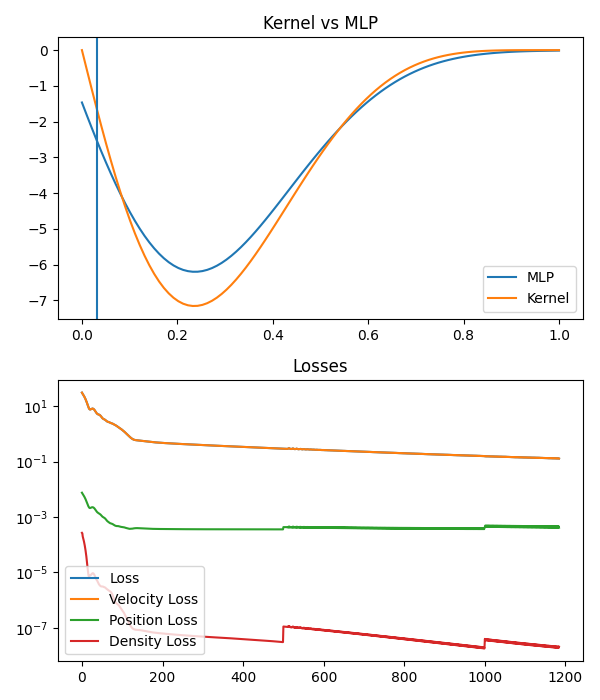

In [ ]:
fig, axis = plt.subplots(2, 1, figsize=(6, 7), squeeze=False)
x = torch.linspace(0, 1, 100).to(device = device, dtype = dtype).view(-1, 1)

# q_ij = (neighbors.get('noghost')[1].r_ij / h_i).view(-1, 1)
mlpResult = runMLP_(
    edgeMLP1,
    basisEncoderLayer(
        x,
        basisTerms,
        basisFunction,
        basisMode
    ),
    batches = 1 
)
kernelResult = eval_dkdq(kernel, x, 2) * eval_C_d(kernel, 2)

axis[0,0].plot(x.cpu().numpy(), mlpResult.cpu().detach().numpy(), label = 'MLP')
axis[0,0].plot(x.cpu().numpy(), kernelResult.cpu().detach().numpy(), label = 'Kernel')


axis[0,0].set_title('Kernel vs MLP')
axis[0,0].legend()

axis[1,0].plot(losses, label = 'Loss')
axis[1,0].plot(vLosses, label = 'Velocity Loss')
axis[1,0].plot(pLosses, label = 'Position Loss')
axis[1,0].plot(rhoLosses, label = 'Density Loss')
axis[1,0].set_title('Losses')
axis[1,0].legend()
axis[1,0].set_yscale('log')

# plt.show()
fig.tight_layout()
